# Installation and configuration of IBL packages

In [ ]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

In [ ]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


# Finding subjects with training data

In [ ]:
import numpy as np

# Find all aggregate training datasets from IBL behaviour paper
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')

# Find the subject name from the info stored in the relative path
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])

# Loading trials data for a single subject

In [ ]:
# Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

# Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL045/#2024-04-10#/_ibl_subjectTrials.table.pqt: 100%|██████████| 9.27M/9.27M [00:00<00:00, 17.4MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/aggregates/Subjects/churchlandlab/CSHL045/_ibl_subjectSessions.table.pqt: 100%|██████████| 8.98k/8.98k [00:00<00:00, 67.5kB/s]


The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.ls81qq9ihg4x) for more information about this dataset.

We can find the number of sessions collected, or the number of times the subject was run under a specific task protocol

In [ ]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')

# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL045 has 76 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.3.1      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5    12
_iblrig_tasks_trainingChoiceWorld6.3.1    11
_iblrig_tasks_biasedChoiceWorld6.2.5       6
_iblrig_tasks_ephysChoiceWorld6.2.5        3
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_ephysChoiceWorld6.4.0        2
_iblrig_tasks_trainingChoiceWorld6.2.0     1
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
Name: count, dtype: int64


We can get the trials data for an individual session of choice, here a the first session using the biasedChoiceWorld protocol

In [ ]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

/usr/local/lib/python3.11/dist-packages/brainbox/behavior/training.py:561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sum(trials['feedbackType'][easy_trials] == 1) / easy_trials.shape[0]


Number of trials for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 682
Performance easy for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 0.9457364341085271


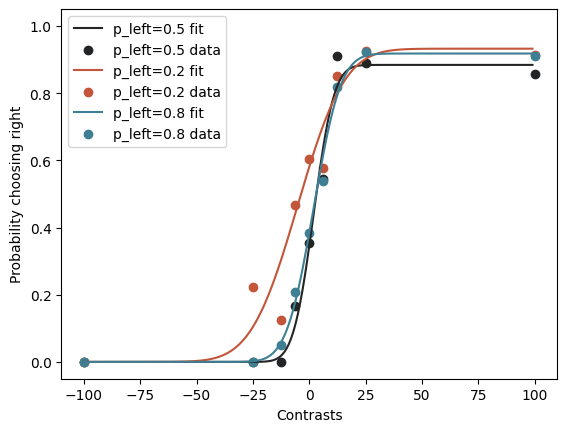

In [ ]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')

## Combining training criteria

Another [dataset](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.18vu2zskyq0r) is available that contains information about the session at which the subject reached certain training criteria in the IBL training pipeline. More information can be found about the training pipeline in the study [A standardized and reproducible method to measure decision-making in mice](https://doi.org/10.1101/2020.01.17.909838).

We can download this dataset in the following way

In [ ]:
subject_training = one.load_aggregate('subjects', subject, '_ibl_subjectTraining.table')

We can combine this with our subject trials table to see how the subject progressed

In [ ]:
subject_trials = (subject_trials
          .join(subject_training.set_index('session'))
          .sort_values(by=['session_start_time', 'intervals_0']))
subject_trials['training_status'] = subject_trials.training_status.fillna(method='ffill')

Our subject trials table now has a new column that indicates the training criteria of the mouse at each session. We can use this information to make a plot of how the performance of the mouse improved across training days.

We will need to compute the performance per session and add this column to our dataframe and also add in a column for training day.

In [ ]:
sessions = subject_trials.index.unique()
for n_sess, sess in enumerate(sessions):
  trials = subject_trials[subject_trials.index == sess]
  perf_easy = compute_performance_easy(trials)
  subject_trials.loc[subject_trials.index == sess, 'performance_easy'] = perf_easy
  subject_trials.loc[subject_trials.index == sess, 'training_day'] = n_sess

Note since we already ordered by session_start_time above our table was already sorted. Here we have simply assigned each training session to a training day but there are some cases where multiple training sessions were run on the same day so this may be something you want to account for in your analysis.

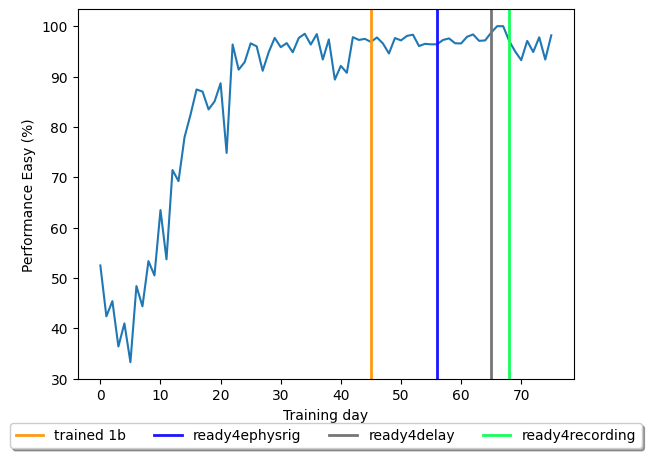

In [ ]:
import matplotlib.pyplot as plt
from ibllib.pipes.training_status import TRAINING_STATUS
fig, ax = plt.subplots(1, 1)
ax.plot(subject_trials['training_day'], subject_trials['performance_easy'] * 100)
ax.set_xlabel("Training day")
ax.set_ylabel("Performance Easy (%)")
status = subject_trials.drop_duplicates(subset='training_status', keep='first')
for _, st in status.iterrows():
    if st['training_status'] in ['untrainable', 'unbiasable']:
        continue
    if TRAINING_STATUS[st['training_status']][0] <= 0:
        continue
    ax.axvline(st['training_day'], linewidth=2,
               color=np.array(TRAINING_STATUS[st['training_status']][1]) / 255, label=st['training_status'])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   fancybox=True, shadow=True, ncol=5)

# Combining data across multiple subjects

We can loop over all the subjects available to get a large dataframe that contains the data for all the subjects. Here is an example of how this can be done


In [ ]:
import pandas as pd

all_trials = []

# Download two tables, subject trials table and subject training table and combine
for i, subject in enumerate(subjects):
  if np.mod(i, 50) == 0:
    print(f'{i}/{len(subjects)}')

  # Load trials table for subject
  subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')

  # Load sessions table for subject
  session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')

  # Load training status for subject
  subject_training = one.load_aggregate('subjects', subject, '_ibl_subjectTraining.table')

  # Combine the two tables
  subject_trials = (subject_trials
            .set_index('session')
            .join(subject_training.set_index('session'))
            .sort_values(by=['session_start_time', 'intervals_0']))
  subject_trials['training_status'] = subject_trials.training_status.fillna(method='ffill')

  # Join sessions table for number, task_protocol, etc.
  if 'task_protocol' in subject_trials:
      subject_trials = subject_trials.drop('task_protocol', axis=1)
  subject_trials = subject_trials.join(session_trials.drop('date', axis=1))

  # Sort the trials by session start time and trial number
  subject_trials = subject_trials.sort_values(by=['session_start_time', 'intervals_0'])


  # add in extra columns for performance easy and training day
  sessions = subject_trials.index.unique()
  for n_sess, sess in enumerate(sessions):
    trials = subject_trials[subject_trials.index == sess]
    perf_easy = compute_performance_easy(trials)
    subject_trials.loc[subject_trials.index == sess, 'performance_easy'] = perf_easy
    subject_trials.loc[subject_trials.index == sess, 'training_day'] = n_sess


  all_trials.append(subject_trials)

all_trials = pd.concat(all_trials)

Once we have this large training table aggregated across all subjects we can manipulate this table to view different properties. For example we can see how the pyshcometric curves varies across the different training stages across all subjects

<Axes: xlabel='signed_contrast', ylabel='choice'>

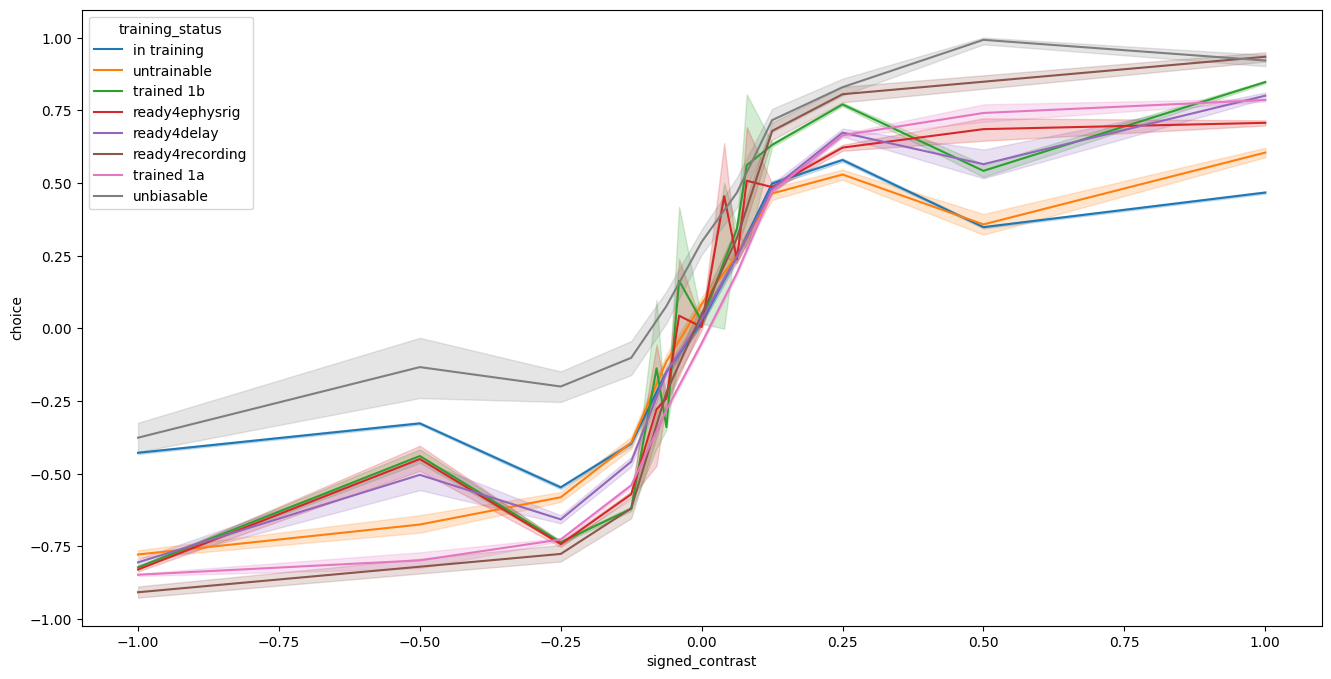

In [ ]:
import seaborn as sns
# plot psychometric curves for the whole dataframe
all_trials = all_trials.reset_index()
all_trials['signed_contrast'] = np.nan
i = np.isnan(all_trials['contrastRight'])
all_trials.loc[i , 'signed_contrast'] = all_trials.loc[i, 'contrastLeft']
all_trials.loc[~i, 'signed_contrast'] = - all_trials.loc[~i, 'contrastRight']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 8))
sns.lineplot(data=all_trials.loc[all_trials['probabilityLeft'] == 0.5], x='signed_contrast', y='choice', hue='training_status', ax=ax)

Or we can look how the performance on easy trial progresses over training days across labs

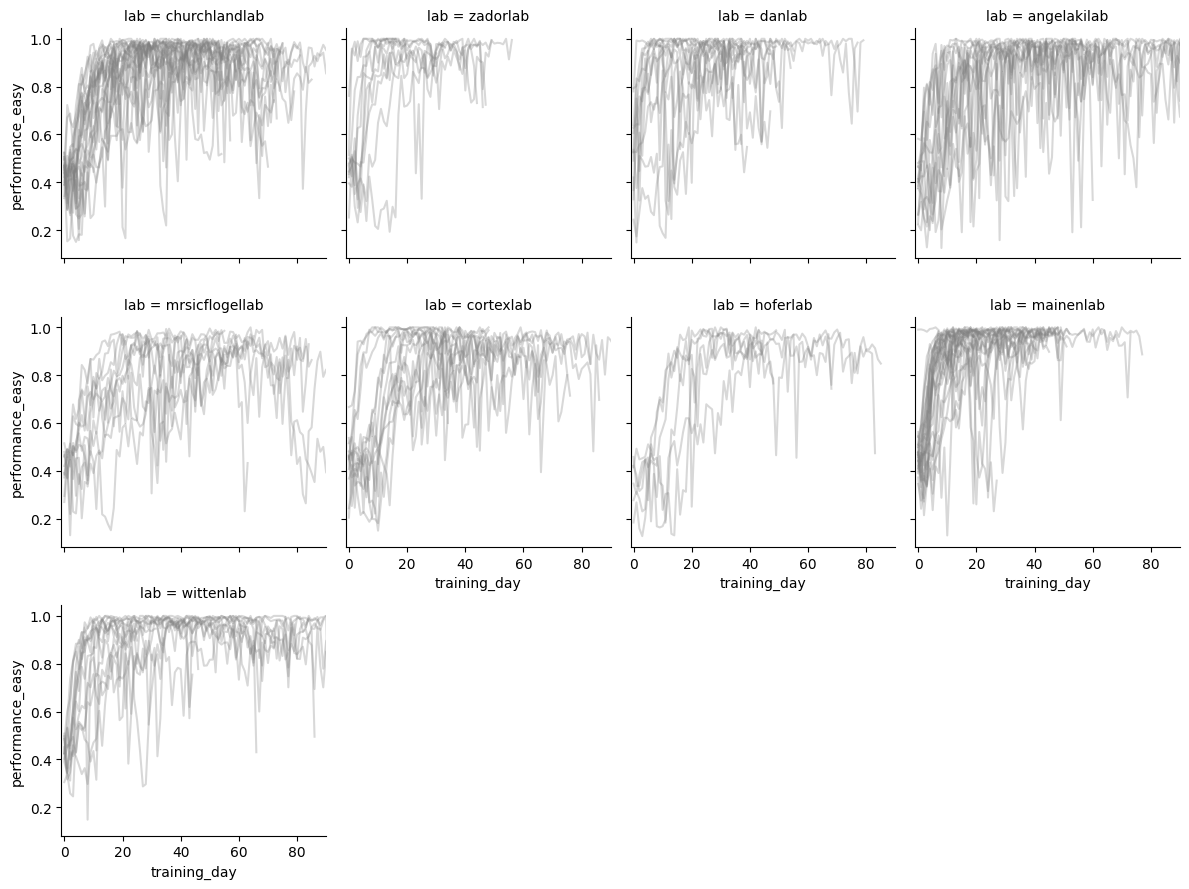

In [ ]:
# Remove duplicate rows that we don't need for the plots
fig = sns.FacetGrid(all_trials.drop_duplicates('session'),
                    col="lab", col_wrap=4,
                    sharex=True, sharey=True, aspect=1, hue="subject", xlim=[-1, 90])
fig.map(sns.lineplot, "training_day",
        "performance_easy", color='gray', alpha=0.3)

# Additional resources

Documentation

- [ONE documentation](https://int-brain-lab.github.io/iblenv/notebooks_external/one_quickstart.html#)
- [Getting started with ONE](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7)
- [Loading trials data](https://int-brain-lab.github.io/iblenv/notebooks_external/loading_trials_data.html)


Where can I find help?
- Issues with the data? Post an issue here: https://neurostars.org/ with the tag `ibl`
- Alternatively post an issue here: https://github.com/int-brain-lab/iblenv/issues
- General questions about the datasets or publications? Email: info@internationalbrainlab.org




> *All data are made available under the CC BY 4.0 license.*